# Limpieza de datos

## Carga de Datos

In [1]:
import pandas as pd

dataset_path = "../data/training.csv"
df_loaded = pd.read_csv(dataset_path)

## Procesamiento de datos

### Resumen del dataset

```pyhon
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                11696 non-null  object 
 1   Store ID            11696 non-null  object 
 2   Product ID          11696 non-null  object 
 3   Category            11696 non-null  object 
 4   Region              11696 non-null  object 
 5   Inventory Level     11696 non-null  int64  
 6   Units Sold          11696 non-null  int64  
 7   Units Ordered       11696 non-null  int64  
 8   Demand Forecast     11696 non-null  float64
 9   Price               11696 non-null  float64
 10  Discount            11696 non-null  int64  
 11  Weather Condition   11696 non-null  object 
 12  Holiday/Promotion   11696 non-null  int64  
 13  Competitor Pricing  11696 non-null  float64
 14  Seasonality         11696 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 1.3+ MB
```

### Conclusion

Como el dataset no presenta datos nulos, se procedera a la transformacion de estos para su posterior limpieza de outliers.
En el dataset se presentan 7 columnas del tipo objetos, una parte de estos se eliminaran al no ser relevantes para la limpieza y el resto se dumificaran

#### Columnas categoricas relevantes

- Seasonality
- Weather Condition
- Region
- Category


### Columnas a eliminar

- Product ID
- Store ID
- Date

### Procesamiento de Datos

- Dumificar
- Escalado Robusto
- Descomponer
- Comprimir
- Limpiar Outliers
- Normalizar (entre -1 y 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# En esta celda dumificaremos el dataset

# Creamos una copia del dataset cargado para luego mutarlo
df_dummified = df_loaded.copy()


# Dropeamos columnas irrelevantes
drop_list = ["Date", "Store ID", "Product ID"]
df_dummified = df_dummified.drop(columns=drop_list)


# Dumificamos el dataset transformando literales en columnas binarias
# Seleccionar columnas categóricas
categorical_columns = ["Category", "Region", "Weather Condition", "Seasonality"]

# Inicializar el codificador
DummyEncoder = OneHotEncoder(sparse_output=False)

# Aplicar transformación
encoded_array = DummyEncoder.fit_transform(df_dummified[categorical_columns])

# Convertir a DataFrame con los nombres de nuevas columnas
encoded_columns = DummyEncoder.get_feature_names_out(categorical_columns)
df_encoded = pd.DataFrame(encoded_array, columns=encoded_columns)

# Concatenar con el DataFrame original, eliminando las columnas originales
df_dummified = df_dummified.drop(columns=categorical_columns).reset_index(drop=True)
df_dummified = pd.concat([df_dummified, df_encoded], axis=1)

# Verificamos dataset dumificado
df_dummified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Inventory Level           11696 non-null  int64  
 1   Units Sold                11696 non-null  int64  
 2   Units Ordered             11696 non-null  int64  
 3   Demand Forecast           11696 non-null  float64
 4   Price                     11696 non-null  float64
 5   Discount                  11696 non-null  int64  
 6   Holiday/Promotion         11696 non-null  int64  
 7   Competitor Pricing        11696 non-null  float64
 8   Category_Clothing         11696 non-null  float64
 9   Category_Electronics      11696 non-null  float64
 10  Category_Furniture        11696 non-null  float64
 11  Category_Groceries        11696 non-null  float64
 12  Category_Toys             11696 non-null  float64
 13  Region_East               11696 non-null  float64
 14  Region

In [ ]:
from sklearn.preprocessing import RobustScaler

# En esta celda normalizamos el dataset dumificado
# creamos una copia para luego mutarla y conservar el original antes trabajado
df_scaled = df_dummified.copy()

# Creamos el escalador
RobustScalerEncoder = RobustScaler()
data_scaled = RobustScalerEncoder.fit_transform(df_scaled)

# Convertimos a Dataframe el dataset escalado
df_scaled = pd.DataFrame(data_scaled, columns=df_scaled.columns)

# Visualizamos el minimo y maximo de las columnas escaladas
df_scaled.describe().loc[["min", "max"]]

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Category_Clothing,Category_Electronics,...,Region_South,Region_West,Weather Condition_Cloudy,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Autumn,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
min,-1.004405,-0.700162,-0.978022,-0.791868,-1.006312,-1.0,0.0,-1.109927,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.977974,2.502431,1.000000,2.517587,1.004525,1.0,1.0,1.122266,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# En esta celda Descompondremos en componentes principales el dataset normalizado
pca = PCA()
pca.fit(df_scaled)

# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
mean_variance = explained_variance.mean() # Media de la varianza explicada

# Ponderamos la varianza media para incluir mas componentes principales
# y aumentar la varianza total explicada
weighted_mean_variance = mean_variance * 0.82

# Seleccionamos los Indices de componentes relevantes
selected_components = np.where(explained_variance > weighted_mean_variance)[0]

# Aplicar PCA con solo las componentes seleccionadas
PCAEncoder = PCA(n_components=len(selected_components))
compressed_data = PCAEncoder.fit_transform(df_scaled)

# Convertir a DataFrame
df_compressed = pd.DataFrame(compressed_data)

# Calculamos la varianza total explicada de las componentes seleccionadas
total_explained_variance = np.sum(explained_variance[selected_components]) * 100


print(f"Varianza Total Explicada: {total_explained_variance:.2f}%")
df_compressed.info()
df_compressed.describe().loc[["min", "max"]]

Varianza Total Explicada: 87.31%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       11696 non-null  float64
 1   1       11696 non-null  float64
 2   2       11696 non-null  float64
 3   3       11696 non-null  float64
 4   4       11696 non-null  float64
 5   5       11696 non-null  float64
 6   6       11696 non-null  float64
 7   7       11696 non-null  float64
 8   8       11696 non-null  float64
 9   9       11696 non-null  float64
 10  10      11696 non-null  float64
 11  11      11696 non-null  float64
 12  12      11696 non-null  float64
 13  13      11696 non-null  float64
 14  14      11696 non-null  float64
dtypes: float64(15)
memory usage: 1.3 MB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
min,-1.629241,-1.579025,-1.098214,-1.107392,-0.885963,-1.201481,-1.141565,-1.090507,-1.157028,-1.359411,-1.322034,-1.049590,-1.223440,-1.021118,-0.708264
max,3.442748,1.546657,1.086248,1.091276,1.509821,1.335255,1.433321,1.246546,1.243212,1.138046,1.172686,1.229951,1.275969,1.502859,1.129975


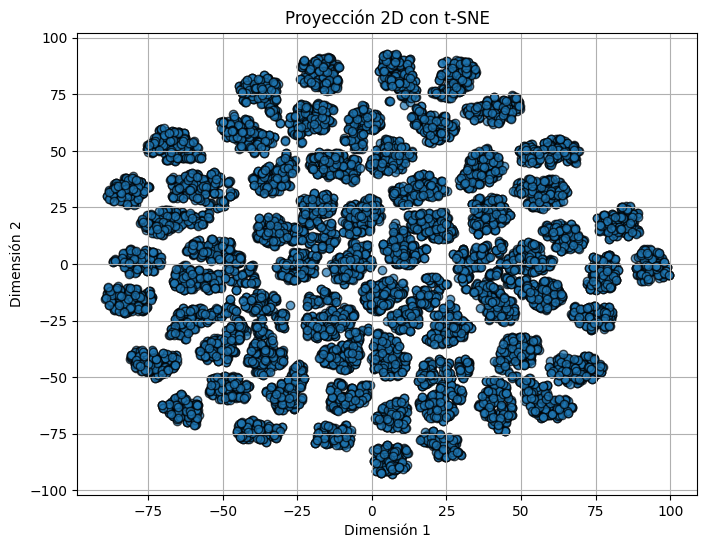

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# AVISO: Esta celda tiene un alto coste computacional para renderizar el grafico
# Aplicar t-SNE para reducir a 2 dimensiones
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
df_2d = tsne.fit_transform(df_compressed)

# Graficar los puntos en 2D
plt.figure(figsize=(8, 6))
plt.scatter(df_2d[:, 0], df_2d[:, 1], alpha=0.7, edgecolors="k")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.title("Proyección 2D con t-SNE")
plt.grid(True)
plt.show()


# Cambiar los indices del Data Frame final por la columna Date
### Filtar los indices eliminados antes de agregar las columnas

In [ ]:
from sklearn.ensemble import IsolationForest

# Instanciar modelo Isolation Forest con 5% de outliers
OutlierEncoder = IsolationForest(contamination=0.07, random_state=42)

# Ajustar y predecir directamente sobre df_compressed
predictions = OutlierEncoder.fit_predict(df_compressed)

# Generar máscara de outliers
mask_outliers = predictions == -1

# Filtrar DataFrame (quedarse con los datos válidos)
df_filtered = df_compressed.loc[~mask_outliers].copy()

# Validar que no se haya eliminado más del 5% del dataset
percentage_removed = mask_outliers.mean() * 100
print(f"🔎 Total de filas fueron que fueron eliminadas como outliers: {mask_outliers.sum()} ({percentage_removed:.2f}%)")

🔎 Total de filas fueron que fueron eliminadas como outliers: 819 (7.00%)


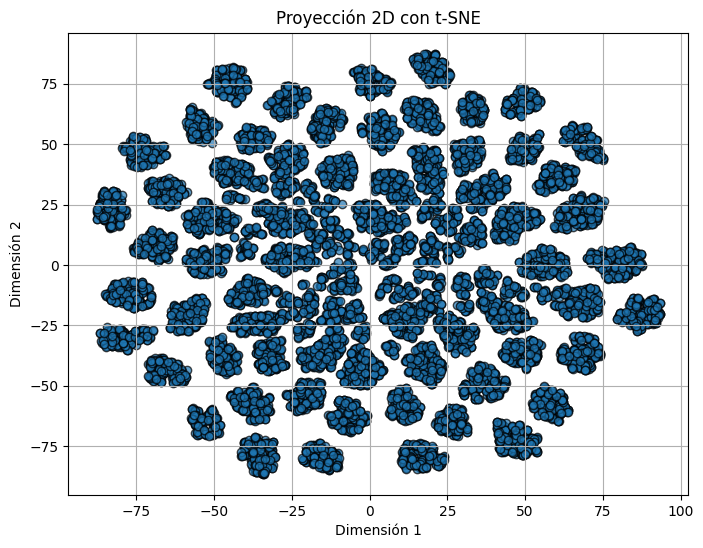

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# AVISO: Esta celda tiene un alto coste computacional para renderizar el grafico
# Aplicar t-SNE para reducir a 2 dimensiones
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
df_2d = tsne.fit_transform(df_filtered)

# Graficar los puntos en 2D
plt.figure(figsize=(8, 6))
plt.scatter(df_2d[:, 0], df_2d[:, 1], alpha=0.7, edgecolors="k")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.title("Proyección 2D con t-SNE")
plt.grid(True)
plt.show()


### Normalizar entre -1 y 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Instanciar MinMaxScaler con rango de -1 a 1
NormalizeEncoder = MinMaxScaler(feature_range=(-1, 1))

data_normalized = NormalizeEncoder.fit_transform(df_filtered)

# Ajustar y transformar directamente sobre df_filtered
df_normalized = pd.DataFrame(data_normalized)

df_normalized.info()
df_normalized.describe().loc[["min", "max"]]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10877 entries, 0 to 10876
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10877 non-null  float64
 1   1       10877 non-null  float64
 2   2       10877 non-null  float64
 3   3       10877 non-null  float64
 4   4       10877 non-null  float64
 5   5       10877 non-null  float64
 6   6       10877 non-null  float64
 7   7       10877 non-null  float64
 8   8       10877 non-null  float64
 9   9       10877 non-null  float64
 10  10      10877 non-null  float64
 11  11      10877 non-null  float64
 12  12      10877 non-null  float64
 13  13      10877 non-null  float64
 14  14      10877 non-null  float64
dtypes: float64(15)
memory usage: 1.2 MB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Cambiar los indices del Data Frame final por la columna Date
### Filtar los indices eliminados antes de agregar las columnas

In [21]:
# Extraer la columna 'Date' desde df_loaded, filtrando primero los outliers eliminados antes de agregar las columnas
dates = df_loaded[mask_outliers == False]["Date"]

# TODO @Seba1996c Agregar fechas a normalized



### Guardar DataFrame final como lstm_training_normalizado.csv

In [10]:
# Guardar el DataFrame final como CSV en ../data
df_normalized.to_csv('../data/lstm_training_normalizado.csv')

### Guardar todos los encoders generados y crear una pipeline 

In [ ]:
from sklearn.pipeline import Pipeline
import joblib

# Crear pipeline con el MinMaxScaler utilizado
pipeline = Pipeline([
    ('DummyEncoder', DummyEncoder),
    # TODO Agregar el resto de encoders
    ('scaler', RobustScalerEncoder)
])

# Guardar la pipeline como archivo .pkl
joblib.dump(pipeline, '../data/pipeline_scaler.pkl')

['../data/pipeline_scaler.pkl']